### Loading Packages and Data

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws
from db_queries import get_population

import altair as alt
from vega_datasets import data

In [48]:
ls /mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/results/ #19.5_51_locations/results_data/

19.5_51_locations/                 21_mediation/  seed-testing/
19_adjusting_therapeutic_inertia/  draw-testing/


In [49]:
sim_results_dir = '/mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/results/19.5_51_locations/results_data/'

# Loading and Cleaning Data

### Load Data

In [4]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')

state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 

In [50]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv').reset_index()
yll = yll.rename(columns = {'value':'yll'})
yld = pd.read_csv(sim_results_dir + 'ylds.csv').reset_index()
yld = yld.rename(columns = {'value':'yld', 'cause_of_disability':'cause'})
daly = yll.merge(yld, on = ['sex','year','cause','input_draw','scenario','age','location'], how='left')
daly['daly'] = daly.yll.fillna(0) + daly.yld.fillna(0)
daly = daly[['sex','year','cause','input_draw','scenario','age','location','yll','yld','daly']]
daly.head()

,sex,year,cause,input_draw,scenario,age,location,yll,yld,daly
0,Female,2021,acute_ischemic_stroke,829,baseline,25_to_29,washington,0.0,0.000088,0.000088
1,Female,2021,acute_ischemic_stroke,829,lifestyle_100,25_to_29,washington,0.0,0.000088,0.000088
2,Female,2021,acute_ischemic_stroke,829,outreach_100,25_to_29,washington,0.0,0.000088,0.000088
3,Female,2021,acute_ischemic_stroke,829,polypill_100,25_to_29,washington,0.0,0.000088,0.000088
4,Female,2021,acute_ischemic_stroke,829,baseline,30_to_34,washington,0.0,0.000000,0.000000


### Load Population Data for Scaling 

In [6]:
US_pop = get_population(age_group_id=157, 
                              location_id=[102,523, 524, 525, 526, 527, 528, 529, 530,531, 532, 533,534, 535,
                                           536, 537, 538, 539, 540,541, 542, 543, 544 ,545, 546, 547, 548, 549, 550,
                                           551, 552, 553, 554, 555, 556, 557, 558, 559, 560,561, 562, 563, 564, 565, 
                                           566, 567, 568, 569, 570,571, 572, 573], 
                              year_id=2019, 
                              sex_id=3, 
                              release_id=9)
US_pop.head()

,age_group_id,location_id,year_id,sex_id,population,run_id
0,157,102,2019,3,2.260218e+08,359
1,157,523,2019,3,3.425549e+06,359
2,157,524,2019,3,4.848432e+05,359
3,157,525,2019,3,4.812495e+06,359
4,157,526,2019,3,2.020596e+06,359


In [7]:
location_map = pd.read_csv('/ihme/homes/lutzes/vivarium_research_nih_us_cvd/CVD_locations.csv')
US_pop = US_pop.merge(location_map,on=['location_id'])
US_pop['scalar'] = US_pop['population'] / 50_000
US_pop

,age_group_id,location_id,year_id,sex_id,population,run_id,location_name,abbreviation,scalar
0,157,102,2019,3,2.260218e+08,359,US,US,4520.435794
1,157,523,2019,3,3.425549e+06,359,Alabama,AL,68.510979
2,157,524,2019,3,4.848432e+05,359,Alaska,AK,9.696864
3,157,525,2019,3,4.812495e+06,359,Arizona,AZ,96.249902
...,...,...,...,...,...,...,...,...,...
48,157,570,2019,3,5.265596e+06,359,Washington,WA,105.311924
49,157,571,2019,3,1.283409e+06,359,West Virginia,WV,25.668176
50,157,572,2019,3,4.056749e+06,359,Wisconsin,WI,81.134990
51,157,573,2019,3,3.913808e+05,359,Wyoming,WY,7.827615


In [8]:
def q25(x):
    return x.quantile(0.025)

def q975(x):
    return x.quantile(0.975)

def convert(word):
    return ' '.join(x.capitalize() or '_' for x in word.split('_'))

# Total Events Averted in Total Pop

In [9]:
tran['transition_new'] = np.where(tran.transition.isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction','heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction']), 'Myocardial Infarction', np.where(tran.transition.isin(['susceptible_to_ischemic_stroke_to_acute_ischemic_stroke','chronic_ischemic_stroke_to_acute_ischemic_stroke']),'Ischemic Stroke','Heart Failure'))
tran_state = tran.groupby(['input_draw','scenario','location','transition_new']).value.sum().reset_index()
tran_state['location_name'] = tran_state.location.apply(convert)
tran_state = tran_state.merge(US_pop[['location_name','abbreviation','scalar']], on=['location_name'])
tran_state['total_count'] = tran_state['value'] * tran_state['scalar']
tran_state.head()

,input_draw,scenario,location,transition_new,value,location_name,abbreviation,scalar,total_count
0,829,baseline,alabama,Heart Failure,11726.0,Alabama,AL,68.510979,803359.744102
1,829,baseline,alabama,Ischemic Stroke,1250.0,Alabama,AL,68.510979,85638.724213
2,829,baseline,alabama,Myocardial Infarction,3603.0,Alabama,AL,68.510979,246845.058673
3,829,lifestyle_100,alabama,Heart Failure,11667.0,Alabama,AL,68.510979,799317.596319
4,829,lifestyle_100,alabama,Ischemic Stroke,1241.0,Alabama,AL,68.510979,85022.125399


In [10]:
tran_state_baseline = tran_state.loc[tran_state.scenario == 'baseline']
tran_state_baseline = tran_state_baseline.rename(columns = {'total_count':'baseline'})
tran_state_total = tran_state.merge(tran_state_baseline[['input_draw','location_name','transition_new','baseline']], on=['input_draw','location_name','transition_new']) 
tran_state_total['averted_count'] = tran_state_total['baseline'] - tran_state_total['total_count']
tran_state_total.head()

,input_draw,scenario,location,transition_new,value,location_name,abbreviation,scalar,total_count,baseline,averted_count
0,829,baseline,alabama,Heart Failure,11726.0,Alabama,AL,68.510979,803359.744102,803359.744102,0.000000
1,829,lifestyle_100,alabama,Heart Failure,11667.0,Alabama,AL,68.510979,799317.596319,803359.744102,4042.147783
2,829,outreach_100,alabama,Heart Failure,11682.0,Alabama,AL,68.510979,800345.261009,803359.744102,3014.483092
3,829,polypill_100,alabama,Heart Failure,11357.0,Alabama,AL,68.510979,778079.192714,803359.744102,25280.551388
4,829,baseline,alabama,Ischemic Stroke,1250.0,Alabama,AL,68.510979,85638.724213,85638.724213,0.000000


In [11]:
tran_state_total_summ = tran_state_total.groupby(['scenario','location_name','transition_new']).averted_count.mean().reset_index()
tran_state_total_summ = tran_state_total_summ.loc[tran_state_total_summ.scenario != 'baseline']
tran_state_total_summ.head()

,scenario,location_name,transition_new,averted_count
150,lifestyle_100,Alabama,Heart Failure,4042.147783
151,lifestyle_100,Alabama,Ischemic Stroke,616.598814
152,lifestyle_100,Alabama,Myocardial Infarction,2603.417216
153,lifestyle_100,Alaska,Heart Failure,349.087106
154,lifestyle_100,Alaska,Ischemic Stroke,58.181184


In [12]:
tran_us_total_summ = tran_state_total_summ.groupby(['scenario','transition_new']).averted_count.sum().reset_index()
tran_us_total_summ = tran_us_total_summ.loc[tran_us_total_summ.transition_new != 'Heart Failure']
tran_us_total_summ

,scenario,transition_new,averted_count
1,lifestyle_100,Ischemic Stroke,5.145380e+04
2,lifestyle_100,Myocardial Infarction,1.782432e+05
4,outreach_100,Ischemic Stroke,6.539988e+04
5,outreach_100,Myocardial Infarction,2.635517e+05
7,polypill_100,Ischemic Stroke,3.920232e+05
8,polypill_100,Myocardial Infarction,1.397485e+06


In [13]:
tran_state_total_summ.to_csv('/ihme/homes/lutzes/events_averted_state_8_31_23.csv')

# Create Dataset with Needed Outcomes 
•	MI, stroke, and HF incidence rates + counts 

•	IHD (MI + post-MI + HF from IHD), stroke, and HF DALYs 

•	Percent change and counts 

•	National and PDFs with states 

### Starting with Incidence Counts for MI, stroke, and HF 

In [14]:
person_time = person_time.groupby(['input_draw','year','scenario','location']).value.sum().reset_index()
person_time_allyears = person_time.groupby(['input_draw','scenario','location']).value.sum().reset_index()
person_time_allyears = person_time_allyears.rename(columns = {'value':'ptvalue'})
person_time = person_time.rename(columns = {'value':'ptvalue'})
#person_time

In [15]:
tran['transition_new'] = np.where(tran.transition.isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction','heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction']), 'Myocardial Infarction', np.where(tran.transition.isin(['susceptible_to_ischemic_stroke_to_acute_ischemic_stroke','chronic_ischemic_stroke_to_acute_ischemic_stroke']),'Ischemic Stroke','Heart Failure'))
tran_state_rate = tran.groupby(['input_draw','year','scenario','location','transition_new']).value.sum().reset_index()
tran_state_rate['location_name'] = tran_state_rate.location.apply(convert)
tran_state_rate = tran_state_rate.merge(US_pop[['location_name','abbreviation','scalar']], on=['location_name']).merge(
                             person_time[['input_draw','year','scenario','location','ptvalue']], on=['input_draw','year','scenario','location'])
tran_state_rate['rate'] = tran_state_rate['value'] / tran_state_rate['ptvalue']
#tran_state_rate

In [16]:
tran['transition_new'] = np.where(tran.transition.isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction','heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction']), 'Myocardial Infarction', np.where(tran.transition.isin(['susceptible_to_ischemic_stroke_to_acute_ischemic_stroke','chronic_ischemic_stroke_to_acute_ischemic_stroke']),'Ischemic Stroke','Heart Failure'))
tran_state_rate_allyear = tran.groupby(['input_draw','scenario','location','transition_new']).value.sum().reset_index()
tran_state_rate_allyear['location_name'] = tran_state_rate_allyear.location.apply(convert)
tran_state_rate_allyear = tran_state_rate_allyear.merge(US_pop[['location_name','abbreviation','scalar']], on=['location_name']).merge(
                             person_time_allyears[['input_draw','scenario','location','ptvalue']], on=['input_draw','scenario','location'])
tran_state_rate_allyear['rate'] = tran_state_rate_allyear['value'] / tran_state_rate_allyear['ptvalue']
tran_state_rate_allyear.head()

,input_draw,scenario,location,transition_new,value,location_name,abbreviation,scalar,ptvalue,rate
0,829,baseline,alabama,Heart Failure,11726.0,Alabama,AL,68.510979,719947.192334,0.016287
1,829,baseline,alabama,Ischemic Stroke,1250.0,Alabama,AL,68.510979,719947.192334,0.001736
2,829,baseline,alabama,Myocardial Infarction,3603.0,Alabama,AL,68.510979,719947.192334,0.005005
3,829,lifestyle_100,alabama,Heart Failure,11667.0,Alabama,AL,68.510979,720205.459274,0.016200
4,829,lifestyle_100,alabama,Ischemic Stroke,1241.0,Alabama,AL,68.510979,720205.459274,0.001723


In [17]:
tran_state_rate_allyear_baseline = tran_state_rate_allyear.loc[tran_state_rate_allyear.scenario == 'baseline']
tran_state_rate_allyear_baseline = tran_state_rate_allyear_baseline.rename(columns = {'rate':'baseline'})
tran_state_rate_allyear_total = tran_state_rate_allyear.merge(tran_state_rate_allyear_baseline[['input_draw','location_name','transition_new','baseline']], on=['input_draw','location_name','transition_new']) 
tran_state_rate_allyear_total['averted_count'] = tran_state_rate_allyear_total['baseline'] - tran_state_rate_allyear_total['rate']
tran_state_rate_allyear_total['averted_percent'] = 100*((tran_state_rate_allyear_total['baseline'] - tran_state_rate_allyear_total['rate'])/tran_state_rate_allyear_total['baseline'])
tran_state_rate_allyear_total.head()

,input_draw,scenario,location,transition_new,value,location_name,abbreviation,scalar,ptvalue,rate,baseline,averted_count,averted_percent
0,829,baseline,alabama,Heart Failure,11726.0,Alabama,AL,68.510979,719947.192334,0.016287,0.016287,0.000000,0.000000
1,829,lifestyle_100,alabama,Heart Failure,11667.0,Alabama,AL,68.510979,720205.459274,0.016200,0.016287,0.000088,0.538835
2,829,outreach_100,alabama,Heart Failure,11682.0,Alabama,AL,68.510979,720210.212183,0.016220,0.016287,0.000067,0.411617
3,829,polypill_100,alabama,Heart Failure,11357.0,Alabama,AL,68.510979,721479.775496,0.015741,0.016287,0.000546,3.352591
4,829,baseline,alabama,Ischemic Stroke,1250.0,Alabama,AL,68.510979,719947.192334,0.001736,0.001736,0.000000,0.000000


In [18]:
tran_state_rate_baseline = tran_state_rate.loc[tran_state_rate.scenario == 'baseline']
tran_state_rate_baseline = tran_state_rate_baseline.rename(columns = {'rate':'baseline'})
tran_state_rate_total = tran_state_rate.merge(tran_state_rate_baseline[['input_draw','year','location_name','transition_new','baseline']], on=['input_draw','year','location_name','transition_new']) 
tran_state_rate_total['averted_count'] = tran_state_rate_total['baseline'] - tran_state_rate_total['rate']
tran_state_rate_total['averted_percent'] = 100*((tran_state_rate_total['baseline'] - tran_state_rate_total['rate'])/tran_state_rate_total['baseline'])
#tran_state_rate_total.head()

In [19]:
tran_state_rate_summ = (tran_state_rate_total
                      .groupby(['year','location_name','abbreviation','transition_new','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'rate':['mean',q25,q975]}))
#tran_state_rate_summ.head()

In [20]:
tran_state_rate_allyear_summ = (tran_state_rate_allyear_total
                      .groupby(['location_name','abbreviation','transition_new','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'rate':['mean',q25,q975]}))
tran_state_rate_allyear_summ.head()

averted_count  \
                                                                  mean   
location_name abbreviation transition_new  scenario                      
Alabama       AL           Heart Failure   baseline           0.000000   
                                           lifestyle_100      0.000088   
                                           outreach_100       0.000067   
                                           polypill_100       0.000546   
                           Ischemic Stroke baseline           0.000000   

                                                                              \
                                                               q25      q975   
location_name abbreviation transition_new  scenario                            
Alabama       AL           Heart Failure   baseline       0.000000  0.000000   
                                           lifestyle_100  0.000088  0.000088   
                                           outreach_100   0.000067  0.000067   
                                           polypill_100   0.000546  0.000546   
                           Ischemic Stroke baseline       0.000000  0.000000   

                                                         averted_percent  \
                                                                    mean   
location_name abbreviation transition_new  scenario                        
Alabama       AL           Heart Failure   baseline             0.000000   
                                           lifestyle_100        0.538835   
                                           outreach_100         0.411617   
                                           polypill_100         3.352591   
                           Ischemic Stroke baseline             0.000000   

                                                                              \
                                                               q25      q975   
location_name abbreviation transition_new  scenario                            
Alabama       AL           Heart Failure   baseline       0.000000  0.000000   
                                           lifestyle_100  0.538835  0.538835   
                                           outreach_100   0.411617  0.411617   
                                           polypill_100   3.352591  3.352591   
                           Ischemic Stroke baseline       0.000000  0.000000   

                                                              rate            \
                                                              mean       q25   
location_name abbreviation transition_new  scenario                            
Alabama       AL           Heart Failure   baseline       0.016287  0.016287   
                                           lifestyle_100  0.016200  0.016200   
                                           outreach_100   0.016220  0.016220   
                                           polypill_100   0.015741  0.015741   
                           Ischemic Stroke baseline       0.001736  0.001736   

                                                                    
                                                              q975  
location_name abbreviation transition_new  scenario                 
Alabama       AL           Heart Failure   baseline       0.016287  
                                           lifestyle_100  0.016200  
                                           outreach_100   0.016220  
                                           polypill_100   0.015741  
                           Ischemic Stroke baseline       0.001736

In [21]:
tran_state_rate_summ.columns = ["_".join(a) for a in tran_state_rate_summ.columns.to_flat_index()]
tran_state_rate_summ.reset_index(inplace=True)
tran_state_rate_summ.loc[(tran_state_rate_summ.scenario == 'baseline') & (tran_state_rate_summ.transition_new == 'Heart Failure')]
#tran_state_rate_summ.head()

,year,location_name,abbreviation,transition_new,scenario,averted_count_mean,averted_count_q25,averted_count_q975,averted_percent_mean,averted_percent_q25,averted_percent_q975,rate_mean,rate_q25,rate_q975
0,2021,Alabama,AL,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.016511,0.016511,0.016511
12,2021,Alaska,AK,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.010406,0.010406,0.010406
24,2021,Arizona,AZ,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.015103,0.015103,0.015103
36,2021,Arkansas,AR,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.016907,0.016907,0.016907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11952,2040,Washington,WA,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.015596,0.015596,0.015596
11964,2040,West Virginia,WV,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.020252,0.020252,0.020252
11976,2040,Wisconsin,WI,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.017680,0.017680,0.017680
11988,2040,Wyoming,WY,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.016282,0.016282,0.016282


In [22]:
tran_state_rate_allyear_summ.columns = ["_".join(a) for a in tran_state_rate_allyear_summ.columns.to_flat_index()]
tran_state_rate_allyear_summ.reset_index(inplace=True)
tran_state_rate_allyear_summ.head()

,location_name,abbreviation,transition_new,scenario,averted_count_mean,averted_count_q25,averted_count_q975,averted_percent_mean,averted_percent_q25,averted_percent_q975,rate_mean,rate_q25,rate_q975
0,Alabama,AL,Heart Failure,baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016287,0.016287,0.016287
1,Alabama,AL,Heart Failure,lifestyle_100,0.000088,0.000088,0.000088,0.538835,0.538835,0.538835,0.016200,0.016200,0.016200
2,Alabama,AL,Heart Failure,outreach_100,0.000067,0.000067,0.000067,0.411617,0.411617,0.411617,0.016220,0.016220,0.016220
3,Alabama,AL,Heart Failure,polypill_100,0.000546,0.000546,0.000546,3.352591,3.352591,3.352591,0.015741,0.015741,0.015741
4,Alabama,AL,Ischemic Stroke,baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001736,0.001736,0.001736


### Now Making Datasets for DALYs for IHD, stroke, and heart failure

In [63]:
daly = daly.loc[daly.cause!='other_causes']
daly['transition_new'] = np.where(daly.cause.isin(['heart_failure_residual']), 'Heart Failure', np.where(daly.cause.isin(['acute_ischemic_stroke','chronic_ischemic_stroke']),'Ischemic Stroke','Ischemic Heart Disease'))
#daly = daly.loc[daly.transition_new!='Heart Failure']
daly_state = daly.groupby(['input_draw','year','scenario','location']).daly.sum().reset_index()
daly_state['location_name'] = daly_state.location.apply(convert)
daly_state_rate = daly_state.merge(US_pop[['location_name','abbreviation','scalar']], on=['location_name'])
daly_state_rate['daly'] = daly_state_rate['daly'] * daly_state_rate['scalar']
daly_state_rate = daly_state_rate.groupby(['input_draw','year','scenario']).daly.sum().reset_index()
daly_state_rate

,input_draw,year,scenario,daly
0,829,2021,baseline,3.149522e+07
1,829,2021,lifestyle_100,3.149522e+07
2,829,2021,outreach_100,3.149522e+07
3,829,2021,polypill_100,3.149522e+07
...,...,...,...,...
76,829,2040,baseline,3.712036e+07
77,829,2040,lifestyle_100,3.704809e+07
78,829,2040,outreach_100,3.690300e+07
79,829,2040,polypill_100,3.624657e+07


In [45]:
daly = daly.loc[daly.cause!='other_causes']
daly['transition_new'] = np.where(daly.cause.isin(['heart_failure_residual']), 'Heart Failure', np.where(daly.cause.isin(['acute_ischemic_stroke','chronic_ischemic_stroke']),'Ischemic Stroke','Ischemic Heart Disease'))
#daly = daly.loc[daly.transition_new!='Heart Failure']
daly_state_allyear = daly.groupby(['input_draw','scenario','location','transition_new']).daly.sum().reset_index()
daly_state_allyear['location_name'] = daly_state_allyear.location.apply(convert)
daly_state_allyear_rate = daly_state_allyear.merge(US_pop[['location_name','abbreviation','scalar']], on=['location_name']).merge(
                             person_time_allyears[['input_draw','scenario','location','ptvalue']], on=['input_draw','scenario','location'])
daly_state_allyear_rate['rate'] = daly_state_allyear_rate['daly'] / daly_state_allyear_rate['ptvalue']
daly_state_allyear_rate.head()

,input_draw,scenario,location,transition_new,daly,location_name,abbreviation,scalar,ptvalue,rate
0,829,baseline,alabama,Heart Failure,62216.649630,Alabama,AL,68.510979,719947.192334,0.086418
1,829,baseline,alabama,Ischemic Heart Disease,93554.422577,Alabama,AL,68.510979,719947.192334,0.129946
2,829,baseline,alabama,Ischemic Stroke,10032.259125,Alabama,AL,68.510979,719947.192334,0.013935
3,829,lifestyle_100,alabama,Heart Failure,62207.615969,Alabama,AL,68.510979,720205.459274,0.086375
4,829,lifestyle_100,alabama,Ischemic Heart Disease,93010.301948,Alabama,AL,68.510979,720205.459274,0.129144


In [64]:
daly_state_rate_baseline = daly_state_rate.loc[daly_state_rate.scenario == 'baseline']
daly_state_rate_baseline = daly_state_rate_baseline.rename(columns = {'daly':'baseline'})
daly_state_rate_total = daly_state_rate.merge(daly_state_rate_baseline[['input_draw','year','baseline']], on=['input_draw','year',]) 
daly_state_rate_total['averted_count'] = daly_state_rate_total['baseline'] - daly_state_rate_total['daly']
daly_state_rate_total['averted_percent'] = 100*((daly_state_rate_total['baseline'] - daly_state_rate_total['daly'])/daly_state_rate_total['baseline'])
#daly_state_rate_total#.head()

In [65]:
daly_state_rate_total

,input_draw,year,scenario,daly,baseline,averted_count,averted_percent
0,829,2021,baseline,3.149522e+07,3.149522e+07,0.000000,0.000000
1,829,2021,lifestyle_100,3.149522e+07,3.149522e+07,0.000000,0.000000
2,829,2021,outreach_100,3.149522e+07,3.149522e+07,0.000000,0.000000
3,829,2021,polypill_100,3.149522e+07,3.149522e+07,0.000000,0.000000
...,...,...,...,...,...,...,...
76,829,2040,baseline,3.712036e+07,3.712036e+07,0.000000,0.000000
77,829,2040,lifestyle_100,3.704809e+07,3.712036e+07,72261.523389,0.194668
78,829,2040,outreach_100,3.690300e+07,3.712036e+07,217358.224032,0.585550
79,829,2040,polypill_100,3.624657e+07,3.712036e+07,873782.662803,2.353918


In [27]:
daly_state_allyear_rate_baseline = daly_state_allyear_rate.loc[daly_state_allyear_rate.scenario == 'baseline']
daly_state_allyear_rate_baseline = daly_state_allyear_rate_baseline.rename(columns = {'rate':'baseline'})
daly_state_allyear_rate_total = daly_state_allyear_rate.merge(daly_state_allyear_rate_baseline[['input_draw','location_name','transition_new','baseline']], on=['input_draw','location_name','transition_new']) 
daly_state_allyear_rate_total['averted_count'] = daly_state_allyear_rate_total['baseline'] - daly_state_allyear_rate_total['rate']
daly_state_allyear_rate_total['averted_percent'] = 100*((daly_state_allyear_rate_total['baseline'] - daly_state_allyear_rate_total['rate'])/daly_state_allyear_rate_total['baseline'])
daly_state_allyear_rate_total.head()

,input_draw,scenario,location,transition_new,daly,location_name,abbreviation,scalar,ptvalue,rate,baseline,averted_count,averted_percent
0,829,baseline,alabama,Heart Failure,62216.649630,Alabama,AL,68.510979,719947.192334,0.086418,0.086418,0.000000,0.000000
1,829,lifestyle_100,alabama,Heart Failure,62207.615969,Alabama,AL,68.510979,720205.459274,0.086375,0.086418,0.000044,0.050375
2,829,outreach_100,alabama,Heart Failure,62095.710096,Alabama,AL,68.510979,720210.212183,0.086219,0.086418,0.000199,0.230833
3,829,polypill_100,alabama,Heart Failure,61352.150015,Alabama,AL,68.510979,721479.775496,0.085037,0.086418,0.001382,1.598969
4,829,baseline,alabama,Ischemic Heart Disease,93554.422577,Alabama,AL,68.510979,719947.192334,0.129946,0.129946,0.000000,0.000000


In [28]:
daly_state_allyear_rate_summ = (daly_state_allyear_rate_total
                      .groupby(['location_name','abbreviation','transition_new','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'rate':['mean',q25,q975]}))
daly_state_allyear_rate_summ.head()

averted_count  \
                                                                         mean   
location_name abbreviation transition_new         scenario                      
Alabama       AL           Heart Failure          baseline           0.000000   
                                                  lifestyle_100      0.000044   
                                                  outreach_100       0.000199   
                                                  polypill_100       0.001382   
                           Ischemic Heart Disease baseline           0.000000   

                                                                           \
                                                                      q25   
location_name abbreviation transition_new         scenario                  
Alabama       AL           Heart Failure          baseline       0.000000   
                                                  lifestyle_100  0.000044   
                                                  outreach_100   0.000199   
                                                  polypill_100   0.001382   
                           Ischemic Heart Disease baseline       0.000000   

                                                                           \
                                                                     q975   
location_name abbreviation transition_new         scenario                  
Alabama       AL           Heart Failure          baseline       0.000000   
                                                  lifestyle_100  0.000044   
                                                  outreach_100   0.000199   
                                                  polypill_100   0.001382   
                           Ischemic Heart Disease baseline       0.000000   

                                                                averted_percent  \
                                                                           mean   
location_name abbreviation transition_new         scenario                        
Alabama       AL           Heart Failure          baseline             0.000000   
                                                  lifestyle_100        0.050375   
                                                  outreach_100         0.230833   
                                                  polypill_100         1.598969   
                           Ischemic Heart Disease baseline             0.000000   

                                                                           \
                                                                      q25   
location_name abbreviation transition_new         scenario                  
Alabama       AL           Heart Failure          baseline       0.000000   
                                                  lifestyle_100  0.050375   
                                                  outreach_100   0.230833   
                                                  polypill_100   1.598969   
                           Ischemic Heart Disease baseline       0.000000   

                                                                           \
                                                                     q975   
location_name abbreviation transition_new         scenario                  
Alabama       AL           Heart Failure          baseline       0.000000   
                                                  lifestyle_100  0.050375   
                                                  outreach_100   0.230833   
                                                  polypill_100   1.598969   
                           Ischemic Heart Disease baseline       0.000000   

                                                                     rate  \
                                                                     mean   
location_name abbreviation transition_new         scenario                  
Alabama       AL           Heart Failure          b

In [69]:
daly_state_rate_total = daly_state_rate_total.loc[daly_state_rate_total.year > 2025]
daly_state_rate_summ = (daly_state_rate_total
                      .groupby(['scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'daly':['mean',q25,q975]}))
#daly_state_rate_summ.head()

In [70]:
daly_state_rate_summ.columns = ["_".join(a) for a in daly_state_rate_summ.columns.to_flat_index()]
daly_state_rate_summ.reset_index(inplace=True)
daly_state_rate_summ#.head()

,scenario,averted_count_mean,averted_count_q25,averted_count_q975,averted_percent_mean,averted_percent_q25,averted_percent_q975,daly_mean,daly_q25,daly_q975
0,baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.511667e+07,3.264270e+07,3.711081e+07
1,lifestyle_100,158234.750336,80732.716318,247135.305452,0.451720,0.225489,0.690175,3.495844e+07,3.246367e+07,3.701031e+07
2,outreach_100,140378.255956,59730.575439,216563.293508,0.400444,0.162558,0.596463,3.497630e+07,3.250320e+07,3.699571e+07
3,polypill_100,880915.781230,729044.259700,991147.404325,2.513985,1.984513,2.871906,3.423576e+07,3.179053e+07,3.633592e+07


In [29]:
daly_state_allyear_rate_summ.columns = ["_".join(a) for a in daly_state_allyear_rate_summ.columns.to_flat_index()]
daly_state_allyear_rate_summ.reset_index(inplace=True)
daly_state_allyear_rate_summ.head()

,location_name,abbreviation,transition_new,scenario,averted_count_mean,averted_count_q25,averted_count_q975,averted_percent_mean,averted_percent_q25,averted_percent_q975,rate_mean,rate_q25,rate_q975
0,Alabama,AL,Heart Failure,baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.086418,0.086418,0.086418
1,Alabama,AL,Heart Failure,lifestyle_100,0.000044,0.000044,0.000044,0.050375,0.050375,0.050375,0.086375,0.086375,0.086375
2,Alabama,AL,Heart Failure,outreach_100,0.000199,0.000199,0.000199,0.230833,0.230833,0.230833,0.086219,0.086219,0.086219
3,Alabama,AL,Heart Failure,polypill_100,0.001382,0.001382,0.001382,1.598969,1.598969,1.598969,0.085037,0.085037,0.085037
4,Alabama,AL,Ischemic Heart Disease,baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.129946,0.129946,0.129946


## DALYs NOT Limited to Specific Causes

In [31]:
daly = daly.loc[daly.cause!='other_causes']
daly['transition_new'] = np.where(daly.cause.isin(['heart_failure_residual']), 'Heart Failure', np.where(daly.cause.isin(['acute_ischemic_stroke','chronic_ischemic_stroke']),'Ischemic Stroke','Ischemic Heart Disease'))
#daly = daly.loc[daly.transition_new!='Heart Failure']
daly_state_allyear = daly.groupby(['input_draw','scenario','location']).daly.sum().reset_index()
daly_state_allyear['location_name'] = daly_state_allyear.location.apply(convert)
daly_state_allyear_rate = daly_state_allyear.merge(US_pop[['location_name','abbreviation','scalar']], on=['location_name'])#.merge(
                             #person_time_allyears[['input_draw','scenario','location','ptvalue']], on=['input_draw','scenario','location'])
daly_state_allyear_rate['rate'] = daly_state_allyear_rate['daly'] #/ daly_state_allyear_rate['ptvalue']
daly_state_allyear_rate.head()

,input_draw,scenario,location,daly,location_name,abbreviation,scalar,rate
0,829,baseline,alabama,165803.331332,Alabama,AL,68.510979,165803.331332
1,829,lifestyle_100,alabama,165202.500544,Alabama,AL,68.510979,165202.500544
2,829,outreach_100,alabama,165020.646561,Alabama,AL,68.510979,165020.646561
3,829,polypill_100,alabama,161822.721219,Alabama,AL,68.510979,161822.721219
4,829,baseline,alaska,128186.689846,Alaska,AK,9.696864,128186.689846


In [32]:
daly_state_allyear_rate_baseline = daly_state_allyear_rate.loc[daly_state_allyear_rate.scenario == 'baseline']
daly_state_allyear_rate_baseline = daly_state_allyear_rate_baseline.rename(columns = {'rate':'baseline'})
daly_state_allyear_rate_total = daly_state_allyear_rate.merge(daly_state_allyear_rate_baseline[['input_draw','location_name','baseline']], on=['input_draw','location_name']) 
daly_state_allyear_rate_total['averted_count'] = daly_state_allyear_rate_total['baseline'] - daly_state_allyear_rate_total['rate']
daly_state_allyear_rate_total['averted_percent'] = 100*((daly_state_allyear_rate_total['baseline'] - daly_state_allyear_rate_total['rate'])/daly_state_allyear_rate_total['baseline'])
daly_state_allyear_rate_total.head()

,input_draw,scenario,location,daly,location_name,abbreviation,scalar,rate,baseline,averted_count,averted_percent
0,829,baseline,alabama,165803.331332,Alabama,AL,68.510979,165803.331332,165803.331332,0.000000,0.000000
1,829,lifestyle_100,alabama,165202.500544,Alabama,AL,68.510979,165202.500544,165803.331332,600.830788,0.362376
2,829,outreach_100,alabama,165020.646561,Alabama,AL,68.510979,165020.646561,165803.331332,782.684771,0.472056
3,829,polypill_100,alabama,161822.721219,Alabama,AL,68.510979,161822.721219,165803.331332,3980.610113,2.400802
4,829,baseline,alaska,128186.689846,Alaska,AK,9.696864,128186.689846,128186.689846,0.000000,0.000000


In [33]:
daly_state_allyear_rate_summ = (daly_state_allyear_rate_total
                      .groupby(['location_name','abbreviation','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'rate':['mean',q25,q975]}))
daly_state_allyear_rate_summ.head()

averted_count               \
                                                  mean          q25   
location_name abbreviation scenario                                   
Alabama       AL           baseline           0.000000     0.000000   
                           lifestyle_100    600.830788   600.830788   
                           outreach_100     782.684771   782.684771   
                           polypill_100    3980.610113  3980.610113   
Alaska        AK           baseline           0.000000     0.000000   

                                                      averted_percent  \
                                                 q975            mean   
location_name abbreviation scenario                                     
Alabama       AL           baseline          0.000000        0.000000   
                           lifestyle_100   600.830788        0.362376   
                           outreach_100    782.684771        0.472056   
                           polypill_100   3980.610113        2.400802   
Alaska        AK           baseline          0.000000        0.000000   

                                                                       rate  \
                                               q25      q975           mean   
location_name abbreviation scenario                                           
Alabama       AL           baseline       0.000000  0.000000  165803.331332   
                           lifestyle_100  0.362376  0.362376  165202.500544   
                           outreach_100   0.472056  0.472056  165020.646561   
                           polypill_100   2.400802  2.400802  161822.721219   
Alaska        AK           baseline       0.000000  0.000000  128186.689846   

                                                                        
                                                    q25           q975  
location_name abbreviation scenario                                     
Alabama       AL           baseline       165803.331332  165803.331332  
                           lifestyle_100  165202.500544  165202.500544  
                           outreach_100   165020.646561  165020.646561  
                           polypill_100   161822.721219  161822.721219  
Alaska        AK           baseline       128186.689846  128186.689846

In [34]:
daly_state_allyear_rate_summ.columns = ["_".join(a) for a in daly_state_allyear_rate_summ.columns.to_flat_index()]
daly_state_allyear_rate_summ.reset_index(inplace=True)
daly_state_allyear_rate_summ.head()

,location_name,abbreviation,scenario,averted_count_mean,averted_count_q25,averted_count_q975,averted_percent_mean,averted_percent_q25,averted_percent_q975,rate_mean,rate_q25,rate_q975
0,Alabama,AL,baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,165803.331332,165803.331332,165803.331332
1,Alabama,AL,lifestyle_100,600.830788,600.830788,600.830788,0.362376,0.362376,0.362376,165202.500544,165202.500544,165202.500544
2,Alabama,AL,outreach_100,782.684771,782.684771,782.684771,0.472056,0.472056,0.472056,165020.646561,165020.646561,165020.646561
3,Alabama,AL,polypill_100,3980.610113,3980.610113,3980.610113,2.400802,2.400802,2.400802,161822.721219,161822.721219,161822.721219
4,Alaska,AK,baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,128186.689846,128186.689846,128186.689846


### Converting Datasets a Bit for Maps

In [ ]:
tran_state_rate_map = pd.DataFrame()
tran_state_rate_map[['year','transition_new','location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean']] = tran_state_rate_summ[['year','transition_new','location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean']]
tran_state_rate_map_2023 = tran_state_rate_map.loc[tran_state_rate_map.year==2023].reset_index()
tran_state_rate_map_2023 = tran_state_rate_map_2023.rename(columns = {'rate_mean':'rate_mean_2023','averted_count_mean':'averted_count_mean_2023','averted_percent_mean':'averted_percent_mean_2023'}).reset_index()
tran_state_rate_map_2040 = tran_state_rate_map.loc[tran_state_rate_map.year==2040].reset_index()
tran_state_rate_map_2040 = tran_state_rate_map_2040.rename(columns = {'rate_mean':'rate_mean_2040','averted_count_mean':'averted_count_mean_2040','averted_percent_mean':'averted_percent_mean_2040'}).reset_index()
tran_state_rate_map = pd.concat([tran_state_rate_map_2023, tran_state_rate_map_2040[['rate_mean_2040','averted_count_mean_2040','averted_percent_mean_2040']]], axis=1)#.reset_index()
#tran_state_rate_map.head()

In [ ]:
pop = data.population_engineers_hurricanes()
pop= pop.rename(columns = {'state':'location_name'})
tran_state_rate_map = tran_state_rate_map.merge(pop[['location_name','id']], on=['location_name'])
#tran_state_rate_map

In [ ]:
daly_state_rate_map = pd.DataFrame()
daly_state_rate_map[['year','transition_new','location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean']] = daly_state_rate_summ[['year','transition_new','location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean']]
daly_state_rate_map_2023 = daly_state_rate_map.loc[daly_state_rate_map.year==2023].reset_index()
daly_state_rate_map_2023 = daly_state_rate_map_2023.rename(columns = {'rate_mean':'rate_mean_2023','averted_count_mean':'averted_count_mean_2023','averted_percent_mean':'averted_percent_mean_2023'})#.reset_index()
daly_state_rate_map_2040 = daly_state_rate_map.loc[daly_state_rate_map.year==2040].reset_index()
daly_state_rate_map_2040 = daly_state_rate_map_2040.rename(columns = {'rate_mean':'rate_mean_2040','averted_count_mean':'averted_count_mean_2040','averted_percent_mean':'averted_percent_mean_2040'}).reset_index()
daly_state_rate_map = pd.concat([daly_state_rate_map_2023, daly_state_rate_map_2040[['rate_mean_2040','averted_count_mean_2040','averted_percent_mean_2040']]], axis=1)#.reset_index()
#daly_state_rate_map#_2023#.head()

In [ ]:
pop = data.population_engineers_hurricanes()
pop= pop.rename(columns = {'state':'location_name'})
daly_state_rate_map = daly_state_rate_map.merge(pop[['location_name','id']], on=['location_name'])

# Make Graphs 


### 2023 vs 2040 Maps for all Outcomes

In [ ]:
daly_state_rate_map.head()

In [ ]:
pd.set_option('display.max_rows', 500)
daly_state_rate_map_ihd = daly_state_rate_map.loc[(daly_state_rate_map.transition_new == 'Ischemic Heart Disease') & daly_state_rate_map.scenario.isin(['baseline','polypill_100'])]
daly_state_rate_map_ihd['scenario_name'] = np.where(daly_state_rate_map_ihd.scenario == 'baseline', 'Baseline', 'FDC antihypertensive')
daly_state_rate_map_ihd = daly_state_rate_map_ihd.loc[(daly_state_rate_map_ihd.location_name != 'West Virginia') & (daly_state_rate_map_ihd.location_name != 'Utah')]
#daly_state_rate_map_ihd = daly_state_rate_map_ihd[['location_name','scenario','rate_mean_2040']]
daly_state_rate_map_ihd#.head()

In [ ]:
tran_state_rate_map_baseline = tran_state_rate_map.loc[(tran_state_rate_map.scenario == 'baseline')]
daly_state_rate_map_baseline = daly_state_rate_map.loc[(daly_state_rate_map.scenario == 'baseline')]
#tran_state_rate_map

In [ ]:
def comparison_years(data_1, outcome): 
    charts = []
    for tran in data_1.transition_new.unique(): 

        subdata = data_1.loc[data_1.transition_new == tran] 
        states = alt.topo_feature(data.us_10m.url, 'states')
        variable_list = ['rate_mean_2023', 'rate_mean_2040']

        background_1 = alt.Chart(states).mark_geoshape(
            fill='lightgray',
            stroke='white'
        ).project('albersUsa').properties(
            width=500,
            height=300
        )

        overlay_1 = alt.Chart(states).mark_geoshape().encode(
            color=alt.Color('rate_mean_2023:Q', title= outcome),
        ).transform_lookup(
            lookup='id',
            from_=alt.LookupData(subdata, 'id', list(subdata.columns))
        ).properties(
            width=500,
            height=300,
            title=f'{tran} {outcome} in 2023'
        ).project(
            type='albersUsa'
        )

        chart_1 = alt.layer(background_1, overlay_1)

        background_2 = alt.Chart(states).mark_geoshape(
            fill='lightgray',
            stroke='white'
        ).project('albersUsa').properties(
            width=500,
            height=300
        )

        overlay_2 = alt.Chart(states).mark_geoshape().encode(
            color='rate_mean_2040:Q'
        ).transform_lookup(
            lookup='id',
            from_=alt.LookupData(subdata, 'id', list(subdata.columns))
        ).properties(
            width=500,
            height=300,
            title=f'{tran} {outcome} in 2040'
        ).project(
            type='albersUsa'
        )

        chart_2 = alt.layer(background_2, overlay_2)

        chart = alt.hconcat(chart_1, chart_2)

        charts.append(chart)
    return charts

In [ ]:
def comparison_2040_scenarios(data_1, outcome): 
    charts = []
    for tran in data_1.scenario_name.unique(): 

        subdata = data_1.loc[data_1.scenario_name == tran] 
        states = alt.topo_feature(data.us_10m.url, 'states')
        variable_list = ['rate_mean_2040']

        background_1 = alt.Chart(states).mark_geoshape(
            fill='lightgray',
            stroke='white'
        ).project('albersUsa').properties(
            width=500,
            height=300
        )

        overlay_1 = alt.Chart(states).mark_geoshape().encode(
            color=alt.Color('rate_mean_2040:Q', title= outcome),
        ).transform_lookup(
            lookup='id',
            from_=alt.LookupData(subdata, 'id', list(subdata.columns))
        ).properties(
            width=500,
            height=300,
            title=f'{tran} IHD {outcome} in 2040'
        ).project(
            type='albersUsa'
        )

        chart = alt.layer(background_1, overlay_1)

        charts.append(chart)
    return charts

In [ ]:
daly_charts = comparison_2040_scenarios(daly_state_rate_map_ihd, 'DALY Rate')
alt.vconcat(*daly_charts)#.resolve_scale(color="independent")

In [ ]:
incidence_charts = comparison_years(tran_state_rate_map_baseline, 'Incidence Rate')
alt.vconcat(*incidence_charts).resolve_scale(color="independent")

In [ ]:
daly_charts = comparison_years(daly_state_rate_map_baseline, 'DALY Rate')
alt.vconcat(*daly_charts).resolve_scale(color="independent")

### Averted Percent by Scenario Maps

In [ ]:
tran_state_rate_map = pd.DataFrame()
tran_state_rate_map[['transition_new','location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean','averted_percent_q25','averted_percent_q975']] = tran_state_rate_allyear_summ[['transition_new','location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean','averted_percent_q25','averted_percent_q975']]
tran_state_rate_map_polypill = tran_state_rate_map.loc[tran_state_rate_map.scenario=='polypill_100'].reset_index()
tran_state_rate_map_polypill = tran_state_rate_map_polypill.rename(columns = {'rate_mean':'rate_mean_polypill','averted_count_mean':'averted_count_mean_polypill','averted_percent_mean':'averted_percent_mean_polypill','averted_percent_q25':'averted_percent_q25_polypill','averted_percent_q975':'averted_percent_q975_polypill'})
tran_state_rate_map_outreach = tran_state_rate_map.loc[tran_state_rate_map.scenario=='outreach_100'].reset_index()
tran_state_rate_map_outreach = tran_state_rate_map_outreach.rename(columns = {'rate_mean':'rate_mean_outreach','averted_count_mean':'averted_count_mean_outreach','averted_percent_mean':'averted_percent_mean_outreach','averted_percent_q25':'averted_percent_q25_outreach','averted_percent_q975':'averted_percent_q975_outreach'})
tran_state_rate_map_lifestyle = tran_state_rate_map.loc[tran_state_rate_map.scenario=='lifestyle_100'].reset_index()
tran_state_rate_map_lifestyle = tran_state_rate_map_lifestyle.rename(columns = {'rate_mean':'rate_mean_lifestyle','averted_count_mean':'averted_count_mean_lifestyle','averted_percent_mean':'averted_percent_mean_lifestyle','averted_percent_q25':'averted_percent_q25_lifestyle','averted_percent_q975':'averted_percent_q975_lifestyle'}).reset_index()
tran_state_rate_map = pd.concat([tran_state_rate_map_polypill, tran_state_rate_map_outreach[['rate_mean_outreach','averted_count_mean_outreach','averted_percent_mean_outreach','averted_percent_q25_outreach','averted_percent_q975_outreach']], tran_state_rate_map_lifestyle[['rate_mean_lifestyle','averted_count_mean_lifestyle','averted_percent_mean_lifestyle','averted_percent_q25_lifestyle','averted_percent_q975_lifestyle']]], axis=1)
tran_state_rate_map.head()

In [ ]:
pop = data.population_engineers_hurricanes()
pop= pop.rename(columns = {'state':'location_name'})
tran_state_rate_map = tran_state_rate_map.merge(pop[['location_name','id']], on=['location_name'])
#tran_state_rate_map

In [44]:
daly_state_rate_map = pd.DataFrame()
daly_state_rate_map[['location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean','averted_percent_q25','averted_percent_q975']] = daly_state_allyear_rate_summ[['location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean','averted_percent_q25','averted_percent_q975']]
daly_state_rate_map_polypill = daly_state_rate_map.loc[daly_state_rate_map.scenario=='polypill_100'].reset_index()
daly_state_rate_map_polypill = daly_state_rate_map_polypill.rename(columns = {'rate_mean':'rate_mean_polypill','averted_count_mean':'averted_count_mean_polypill','averted_percent_mean':'averted_percent_mean_polypill','averted_percent_q25':'averted_percent_q25_polypill','averted_percent_q975':'averted_percent_q975_polypill'})
daly_state_rate_map_outreach = daly_state_rate_map.loc[daly_state_rate_map.scenario=='outreach_100'].reset_index()
daly_state_rate_map_outreach = daly_state_rate_map_outreach.rename(columns = {'rate_mean':'rate_mean_outreach','averted_count_mean':'averted_count_mean_outreach','averted_percent_mean':'averted_percent_mean_outreach','averted_percent_q25':'averted_percent_q25_outreach','averted_percent_q975':'averted_percent_q975_outreach'})
daly_state_rate_map_lifestyle = daly_state_rate_map.loc[daly_state_rate_map.scenario=='lifestyle_100'].reset_index()
daly_state_rate_map_lifestyle = daly_state_rate_map_lifestyle.rename(columns = {'rate_mean':'rate_mean_lifestyle','averted_count_mean':'averted_count_mean_lifestyle','averted_percent_mean':'averted_percent_mean_lifestyle','averted_percent_q25':'averted_percent_q25_lifestyle','averted_percent_q975':'averted_percent_q975_lifestyle'}).reset_index()
daly_state_rate_map = pd.concat([daly_state_rate_map_polypill, daly_state_rate_map_outreach[['rate_mean_outreach','averted_count_mean_outreach','averted_percent_mean_outreach','averted_percent_q25_outreach','averted_percent_q975_outreach']], daly_state_rate_map_lifestyle[['rate_mean_lifestyle','averted_count_mean_lifestyle','averted_percent_mean_lifestyle','averted_percent_q25_lifestyle','averted_percent_q975_lifestyle']]], axis=1)
daly_state_rate_map#.loc[daly_state_rate_map.location_name == 'Alabama']

,index,location_name,abbreviation,scenario,rate_mean_polypill,averted_count_mean_polypill,averted_percent_mean_polypill,averted_percent_q25_polypill,averted_percent_q975_polypill,rate_mean_outreach,averted_count_mean_outreach,averted_percent_mean_outreach,averted_percent_q25_outreach,averted_percent_q975_outreach,rate_mean_lifestyle,averted_count_mean_lifestyle,averted_percent_mean_lifestyle,averted_percent_q25_lifestyle,averted_percent_q975_lifestyle
0,3,Alabama,AL,polypill_100,161822.721219,3980.610113,2.400802,2.400802,2.400802,165020.646561,782.684771,0.472056,0.472056,0.472056,165202.500544,600.830788,0.362376,0.362376,0.362376
1,7,Alaska,AK,polypill_100,125813.560959,2373.128887,1.851307,1.851307,1.851307,127772.654644,414.035202,0.322994,0.322994,0.322994,127730.439605,456.250241,0.355926,0.355926,0.355926
2,11,Arizona,AZ,polypill_100,142684.399200,3616.328258,2.471846,2.471846,2.471846,145614.536328,686.191129,0.469028,0.469028,0.469028,145841.662183,459.065275,0.313782,0.313782,0.313782
3,15,Arkansas,AR,polypill_100,161996.025210,3834.140406,2.312089,2.312089,2.312089,165241.385806,588.779810,0.355050,0.355050,0.355050,165347.003960,483.161656,0.291359,0.291359,0.291359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,187,Washington,WA,polypill_100,129010.879728,3039.822154,2.302011,2.302011,2.302011,131652.939426,397.762455,0.301219,0.301219,0.301219,131735.576353,315.125528,0.238640,0.238640,0.238640
47,191,West Virginia,WV,polypill_100,186279.040168,3375.226884,1.779674,1.779674,1.779674,189004.962623,649.304428,0.342362,0.342362,0.342362,188970.157757,684.109294,0.360714,0.360714,0.360714
48,195,Wisconsin,WI,polypill_100,148934.760520,2850.182425,1.877777,1.877777,1.877777,151152.201980,632.740965,0.416867,0.416867,0.416867,151167.979611,616.963334,0.406472,0.406472,0.406472
49,199,Wyoming,WY,polypill_100,145668.480345,3068.735883,2.063193,2.063193,2.063193,148226.897452,510.318776,0.343101,0.343101,0.343101,147644.093861,1093.122368,0.734935,0.734935,0.734935


In [37]:
daly_state_allyear_rate_summ

,location_name,abbreviation,scenario,averted_count_mean,averted_count_q25,averted_count_q975,averted_percent_mean,averted_percent_q25,averted_percent_q975,rate_mean,rate_q25,rate_q975
0,Alabama,AL,baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,165803.331332,165803.331332,165803.331332
1,Alabama,AL,lifestyle_100,600.830788,600.830788,600.830788,0.362376,0.362376,0.362376,165202.500544,165202.500544,165202.500544
2,Alabama,AL,outreach_100,782.684771,782.684771,782.684771,0.472056,0.472056,0.472056,165020.646561,165020.646561,165020.646561
3,Alabama,AL,polypill_100,3980.610113,3980.610113,3980.610113,2.400802,2.400802,2.400802,161822.721219,161822.721219,161822.721219
...,...,...,...,...,...,...,...,...,...,...,...,...
196,Wyoming,WY,baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,148737.216229,148737.216229,148737.216229
197,Wyoming,WY,lifestyle_100,1093.122368,1093.122368,1093.122368,0.734935,0.734935,0.734935,147644.093861,147644.093861,147644.093861
198,Wyoming,WY,outreach_100,510.318776,510.318776,510.318776,0.343101,0.343101,0.343101,148226.897452,148226.897452,148226.897452
199,Wyoming,WY,polypill_100,3068.735883,3068.735883,3068.735883,2.063193,2.063193,2.063193,145668.480345,145668.480345,145668.480345


In [35]:
daly_state_rate_map = pd.DataFrame()
daly_state_rate_map[['transition_new','location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean','averted_percent_q25','averted_percent_q975']] = daly_state_allyear_rate_summ[['transition_new','location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean','averted_percent_q25','averted_percent_q975']]
daly_state_rate_map_polypill = daly_state_rate_map.loc[daly_state_rate_map.scenario=='polypill_100'].reset_index()
daly_state_rate_map_polypill = daly_state_rate_map_polypill.rename(columns = {'rate_mean':'rate_mean_polypill','averted_count_mean':'averted_count_mean_polypill','averted_percent_mean':'averted_percent_mean_polypill','averted_percent_q25':'averted_percent_q25_polypill','averted_percent_q975':'averted_percent_q975_polypill'})
daly_state_rate_map_outreach = daly_state_rate_map.loc[daly_state_rate_map.scenario=='outreach_100'].reset_index()
daly_state_rate_map_outreach = daly_state_rate_map_outreach.rename(columns = {'rate_mean':'rate_mean_outreach','averted_count_mean':'averted_count_mean_outreach','averted_percent_mean':'averted_percent_mean_outreach','averted_percent_q25':'averted_percent_q25_outreach','averted_percent_q975':'averted_percent_q975_outreach'})
daly_state_rate_map_lifestyle = daly_state_rate_map.loc[daly_state_rate_map.scenario=='lifestyle_100'].reset_index()
daly_state_rate_map_lifestyle = daly_state_rate_map_lifestyle.rename(columns = {'rate_mean':'rate_mean_lifestyle','averted_count_mean':'averted_count_mean_lifestyle','averted_percent_mean':'averted_percent_mean_lifestyle','averted_percent_q25':'averted_percent_q25_lifestyle','averted_percent_q975':'averted_percent_q975_lifestyle'}).reset_index()
daly_state_rate_map = pd.concat([daly_state_rate_map_polypill, daly_state_rate_map_outreach[['rate_mean_outreach','averted_count_mean_outreach','averted_percent_mean_outreach','averted_percent_q25_outreach','averted_percent_q975_outreach']], daly_state_rate_map_lifestyle[['rate_mean_lifestyle','averted_count_mean_lifestyle','averted_percent_mean_lifestyle','averted_percent_q25_lifestyle','averted_percent_q975_lifestyle']]], axis=1)
daly_state_rate_map.loc[daly_state_rate_map.location_name == 'Alabama']

KeyError: "['transition_new'] not in index"

In [38]:
pop = data.population_engineers_hurricanes()
pop= pop.rename(columns = {'state':'location_name'})
daly_state_rate_map = daly_state_rate_map.merge(pop[['location_name','id']], on=['location_name'])
#daly_state_rate_map

In [ ]:
def interventions_maps(data_1, outcome): 
    charts = []

    subdata = data_1#.loc[data_1.transition_new == tran] 
    states = alt.topo_feature(data.us_10m.url, 'states')
    variable_list = ['averted_percent_mean_polypill', 'averted_percent_mean_outreach']

    background_1 = alt.Chart(states).mark_geoshape(
        fill='lightgray',
        stroke='white'
    ).project('albersUsa').properties(
        width=500,
        height=300
    )

    overlay_1 = alt.Chart(states).mark_geoshape().encode(
        color=alt.Color('averted_percent_mean_polypill:Q', title= 'Percent Averted')#, scale=alt.Scale(scheme='blues')),
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(subdata, 'id', list(subdata.columns))
    ).properties(
        width=500,
        height=300,
        title=f'Percent of {outcome} Averted with Polypill'
    ).project(
        type='albersUsa'
    )

    chart_1 = alt.layer(background_1, overlay_1)

    background_3 = alt.Chart(states).mark_geoshape(
        fill='lightgray',
        stroke='white'
    ).project('albersUsa').properties(
        width=500,
        height=300
    )

    overlay_3 = alt.Chart(states).mark_geoshape().encode(
        color=alt.Color('averted_percent_mean_lifestyle:Q', title= 'Percent Averted', scale=alt.Scale(scheme='greens')),
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(subdata, 'id', list(subdata.columns))
    ).properties(
        width=500,
        height=300,
        title=f'Percent of {outcome} Averted with Lifestyle'
    ).project(
        type='albersUsa'
    )

    chart_3 = alt.layer(background_3, overlay_3)
    chart = alt.hconcat(chart_1, chart_3).resolve_scale(color="independent")

    charts.append(chart)
    return charts

In [ ]:
def interventions_maps(data_1, outcome): 
    charts = []
    for tran in data_1.transition_new.unique(): 

        subdata = data_1.loc[data_1.transition_new == tran] 
        states = alt.topo_feature(data.us_10m.url, 'states')
        variable_list = ['averted_percent_mean_polypill', 'averted_percent_mean_outreach']

        background_1 = alt.Chart(states).mark_geoshape(
            fill='lightgray',
            stroke='white'
        ).project('albersUsa').properties(
            width=500,
            height=300
        )

        overlay_1 = alt.Chart(states).mark_geoshape().encode(
            color=alt.Color('averted_percent_mean_polypill:Q', title= 'Percent Averted', scale=alt.Scale(scheme='lightmulti')),
        ).transform_lookup(
            lookup='id',
            from_=alt.LookupData(subdata, 'id', list(subdata.columns))
        ).properties(
            width=500,
            height=300,
            title=f'Percent of {tran} {outcome} Averted with Polypill'
        ).project(
            type='albersUsa'
        )

        chart_1 = alt.layer(background_1, overlay_1)

        background_2 = alt.Chart(states).mark_geoshape(
            fill='lightgray',
            stroke='white'
        ).project('albersUsa').properties(
            width=500,
            height=300
        )

        overlay_2 = alt.Chart(states).mark_geoshape().encode(
            color='averted_percent_mean_outreach:Q'
        ).transform_lookup(
            lookup='id',
            from_=alt.LookupData(subdata, 'id', list(subdata.columns))
        ).properties(
            width=500,
            height=300,
            title=f'Percent of {tran} {outcome} Averted with Outreach'
        ).project(
            type='albersUsa'
        )

        chart_2 = alt.layer(background_2, overlay_2)

        background_3 = alt.Chart(states).mark_geoshape(
            fill='lightgray',
            stroke='white'
        ).project('albersUsa').properties(
            width=500,
            height=300
        )

        overlay_3 = alt.Chart(states).mark_geoshape().encode(
            color='averted_percent_mean_lifestyle:Q'
        ).transform_lookup(
            lookup='id',
            from_=alt.LookupData(subdata, 'id', list(subdata.columns))
        ).properties(
            width=500,
            height=300,
            title=f'Percent of {tran} {outcome} Averted with Lifestyle'
        ).project(
            type='albersUsa'
        )

        chart_3 = alt.layer(background_3, overlay_3)
        chart = alt.hconcat(chart_1, chart_2, chart_3)#.resolve_scale(color="independent")

        charts.append(chart)
    return charts

In [ ]:
def interventions_maps(data_1, outcome): 
    charts = []
    for tran in ['Ischemic Heart Disease']: #]data_1.transition_new.unique(): 

        subdata = data_1.loc[data_1.transition_new == tran] 
        states = alt.topo_feature(data.us_10m.url, 'states')
        variable_list = ['averted_percent_mean_polypill', 'averted_percent_mean_outreach']

        background_1 = alt.Chart(states).mark_geoshape(
            fill='lightgray',
            stroke='white'
        ).project('albersUsa').properties(
            width=500,
            height=300
        )

        overlay_1 = alt.Chart(states).mark_geoshape().encode(
            color=alt.Color('averted_percent_mean_polypill:Q', title= 'Percent Averted') #, scale=alt.Scale(scheme='lightmulti')),
        ).transform_lookup(
            lookup='id',
            from_=alt.LookupData(subdata, 'id', list(subdata.columns))
        ).properties(
            width=500,
            height=300,
            title=f'Percent of {tran} {outcome} averted with FDC antihypertensive'
        ).project(
            type='albersUsa'
        )

        chart_1 = alt.layer(background_1, overlay_1)

        background_2 = alt.Chart(states).mark_geoshape(
            fill='lightgray',
            stroke='white'
        ).project('albersUsa').properties(
            width=500,
            height=300
        )

        overlay_2 = alt.Chart(states).mark_geoshape().encode(
            color=alt.Color('averted_percent_mean_outreach:Q', title= 'Percent Averted') #, scale=alt.Scale(scheme='lightmulti')),
        ).transform_lookup(
            lookup='id',
            from_=alt.LookupData(subdata, 'id', list(subdata.columns))
        ).properties(
            width=500,
            height=300,
            title=f'Percent of {tran} {outcome} averted with nurse intervention to increase medication adherence'
        ).project(
            type='albersUsa'
        )

        chart_2 = alt.layer(background_2, overlay_2)

        background_3 = alt.Chart(states).mark_geoshape(
            fill='lightgray',
            stroke='white'
        ).project('albersUsa').properties(
            width=500,
            height=300
        )

        overlay_3 = alt.Chart(states).mark_geoshape().encode(
            color=alt.Color('averted_percent_mean_lifestyle:Q', title= 'Percent Averted') #, scale=alt.Scale(scheme='lightmulti')),
        ).transform_lookup(
            lookup='id',
            from_=alt.LookupData(subdata, 'id', list(subdata.columns))
        ).properties(
            width=500,
            height=300,
            title=f'Percent of {tran} {outcome} averted with community-based NDPP'
        ).project(
            type='albersUsa'
        )

        chart_3 = alt.layer(background_3, overlay_3)
        chart = alt.hconcat(chart_1, chart_2, chart_3).resolve_scale(color="independent")

        charts.append(chart)
    return charts

In [ ]:
incidence_averted_charts = interventions_maps(tran_state_rate_map, 'Incidence')
alt.vconcat(*incidence_averted_charts).resolve_scale(color="independent")

In [ ]:
daly_averted_charts = interventions_maps(daly_state_rate_map, 'DALYs')
alt.vconcat(*daly_averted_charts).resolve_scale(color="independent")

## Plotting map data differently 

In [39]:
#tran_state_rate_map['upper_error_outreach'] = tran_state_rate_map['averted_percent_q975_outreach'] - tran_state_rate_map['averted_percent_mean_outreach']
#tran_state_rate_map['lower_error_outreach'] = tran_state_rate_map['averted_percent_mean_outreach'] - tran_state_rate_map['averted_percent_q25_outreach']

#tran_state_rate_map['upper_error_polypill'] = tran_state_rate_map['averted_percent_q975_polypill'] - tran_state_rate_map['averted_percent_mean_polypill']
#tran_state_rate_map['lower_error_polypill'] = tran_state_rate_map['averted_percent_mean_polypill'] - tran_state_rate_map['averted_percent_q25_polypill']

#tran_state_rate_map['upper_error_lifestyle'] = tran_state_rate_map['averted_percent_q975_lifestyle'] - tran_state_rate_map['averted_percent_mean_lifestyle']
#tran_state_rate_map['lower_error_lifestyle'] = tran_state_rate_map['averted_percent_mean_lifestyle'] - tran_state_rate_map['averted_percent_q25_lifestyle']

daly_state_rate_map['upper_error_outreach'] = daly_state_rate_map['averted_percent_q975_outreach'] - daly_state_rate_map['averted_percent_mean_outreach']
daly_state_rate_map['lower_error_outreach'] = daly_state_rate_map['averted_percent_mean_outreach'] - daly_state_rate_map['averted_percent_q25_outreach']

daly_state_rate_map['upper_error_polypill'] = daly_state_rate_map['averted_percent_q975_polypill'] - daly_state_rate_map['averted_percent_mean_polypill']
daly_state_rate_map['lower_error_polypill'] = daly_state_rate_map['averted_percent_mean_polypill'] - daly_state_rate_map['averted_percent_q25_polypill']

daly_state_rate_map['upper_error_lifestyle'] = daly_state_rate_map['averted_percent_q975_lifestyle'] - daly_state_rate_map['averted_percent_mean_lifestyle']
daly_state_rate_map['lower_error_lifestyle'] = daly_state_rate_map['averted_percent_mean_lifestyle'] - daly_state_rate_map['averted_percent_q25_lifestyle']


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('incidence_dot_plot_8_31_23.pdf') as pdf:
    for intervention in ['outreach', 'polypill', 'lifestyle']:
        for trans in tran_state_rate_map.transition_new.unique():
            plt.figure(figsize=(12,5))
            subdata = tran_state_rate_map.loc[(tran_state_rate_map.transition_new == trans)].sort_values([f'averted_percent_mean_{intervention}'])
            y_error = [subdata[f'upper_error_{intervention}'], subdata[f'lower_error_{intervention}']]

            plt.errorbar(range(50), subdata[f'averted_percent_mean_{intervention}'], yerr=y_error, fmt='o') 

            for i in range(50):
                plt.annotate(subdata.abbreviation.iloc[i], (i, subdata[f'averted_percent_mean_{intervention}'].iloc[i] + 0.0002))


            plt.title(f'Percent Incidence Averted {trans} in {intervention} Scenario by Location')
            pdf.savefig(bbox_inches='tight')

In [42]:
with PdfPages('daly_dot_plot_11_9_23.pdf') as pdf:
    for intervention in ['outreach', 'polypill', 'lifestyle']:
        for trans in daly_state_rate_map.transition_new.unique():
            plt.figure(figsize=(12, 5))
            subdata = daly_state_rate_map.loc[(daly_state_rate_map.transition_new == trans)].sort_values([f'averted_percent_mean_{intervention}'])
            y_error = [subdata[f'upper_error_{intervention}'], subdata[f'lower_error_{intervention}']]

            plt.errorbar(range(50), subdata[f'averted_percent_mean_{intervention}'], yerr=y_error, fmt='o') 

            for i in range(50):
                plt.annotate(subdata.abbreviation.iloc[i], (i, subdata[f'averted_percent_mean_{intervention}'].iloc[i] + 0.0002))

            plt.title(f'Percent DALYs Averted {trans} in {intervention} Scenario by Location')
            pdf.savefig(bbox_inches='tight')


AttributeError: 'DataFrame' object has no attribute 'transition_new'

In [43]:
daly_state_rate_map

,index,location_name,abbreviation,scenario,rate_mean_polypill,averted_count_mean_polypill,averted_percent_mean_polypill,averted_percent_q25_polypill,averted_percent_q975_polypill,rate_mean_outreach,...,averted_percent_mean_lifestyle,averted_percent_q25_lifestyle,averted_percent_q975_lifestyle,id,upper_error_outreach,lower_error_outreach,upper_error_polypill,lower_error_polypill,upper_error_lifestyle,lower_error_lifestyle
0,3,Alabama,AL,polypill_100,161822.721219,3980.610113,2.400802,2.400802,2.400802,165020.646561,...,0.362376,0.362376,0.362376,1,0.0,0.0,0.0,0.0,0.0,0.0
1,7,Alaska,AK,polypill_100,125813.560959,2373.128887,1.851307,1.851307,1.851307,127772.654644,...,0.355926,0.355926,0.355926,2,0.0,0.0,0.0,0.0,0.0,0.0
2,11,Arizona,AZ,polypill_100,142684.399200,3616.328258,2.471846,2.471846,2.471846,145614.536328,...,0.313782,0.313782,0.313782,4,0.0,0.0,0.0,0.0,0.0,0.0
3,15,Arkansas,AR,polypill_100,161996.025210,3834.140406,2.312089,2.312089,2.312089,165241.385806,...,0.291359,0.291359,0.291359,5,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,187,Washington,WA,polypill_100,129010.879728,3039.822154,2.302011,2.302011,2.302011,131652.939426,...,0.238640,0.238640,0.238640,53,0.0,0.0,0.0,0.0,0.0,0.0
47,191,West Virginia,WV,polypill_100,186279.040168,3375.226884,1.779674,1.779674,1.779674,189004.962623,...,0.360714,0.360714,0.360714,54,0.0,0.0,0.0,0.0,0.0,0.0
48,195,Wisconsin,WI,polypill_100,148934.760520,2850.182425,1.877777,1.877777,1.877777,151152.201980,...,0.406472,0.406472,0.406472,55,0.0,0.0,0.0,0.0,0.0,0.0
49,199,Wyoming,WY,polypill_100,145668.480345,3068.735883,2.063193,2.063193,2.063193,148226.897452,...,0.734935,0.734935,0.734935,56,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Percent DALYs Averted by Scenario, Location')

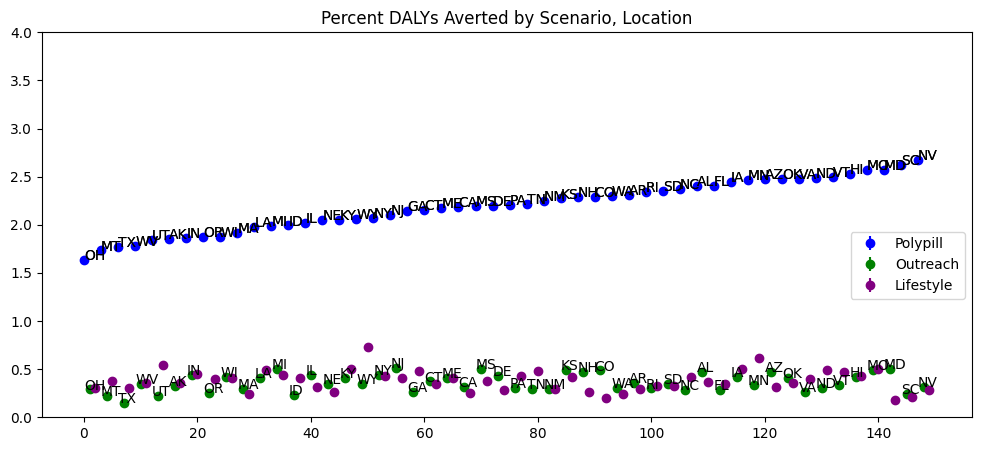

In [41]:
plt.figure(figsize=(12, 5))
subdata = daly_state_rate_map.sort_values([f'averted_percent_mean_polypill'])
y_error_polypill = [subdata[f'upper_error_polypill'], subdata[f'lower_error_polypill']]
y_error_outreach = [subdata[f'upper_error_outreach'], subdata[f'lower_error_outreach']]
y_error_lifestyle = [subdata[f'upper_error_lifestyle'], subdata[f'lower_error_lifestyle']]

plt.errorbar(range(0, 150, 3) , subdata[f'averted_percent_mean_polypill'], yerr=y_error_polypill, fmt='o', color = 'blue', label = 'Polypill') 
plt.errorbar(range(1, 151, 3), subdata[f'averted_percent_mean_outreach'], yerr=y_error_outreach, fmt='o', color = 'green', label = 'Outreach') 
plt.errorbar(range(2, 152, 3), subdata[f'averted_percent_mean_lifestyle'], yerr=y_error_lifestyle, fmt='o', color = 'purple', label = 'Lifestyle') 

for i in range(50):
    plt.annotate(subdata.abbreviation.iloc[i], (i*3+ 0.002, subdata[f'averted_percent_mean_polypill'].iloc[i] ))
    plt.annotate(subdata.abbreviation.iloc[i], (i*3+ 0.002, subdata[f'averted_percent_mean_outreach'].iloc[i] ))
    plt.annotate(subdata.abbreviation.iloc[i], (i*3+ 0.002, subdata[f'averted_percent_mean_polypill'].iloc[i] ))

plt.legend(bbox_to_anchor=(1, 0.5))
plt.ylim(0,4)
plt.xticks()
plt.title(f'Percent DALYs Averted by Scenario, Location')

In [ ]:
daly_state_rate_map

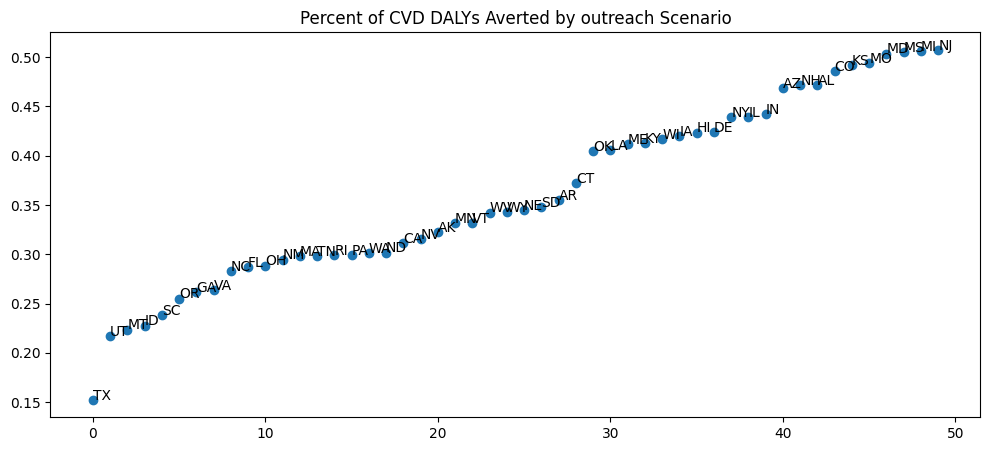

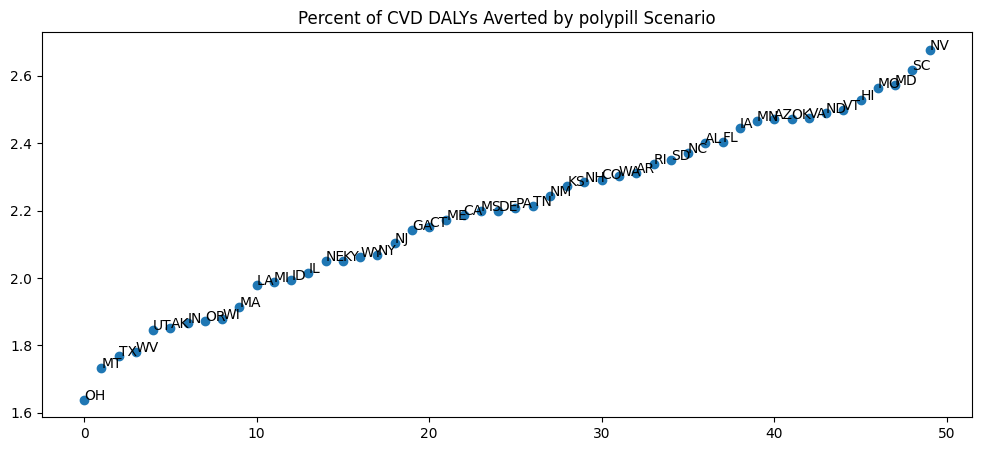

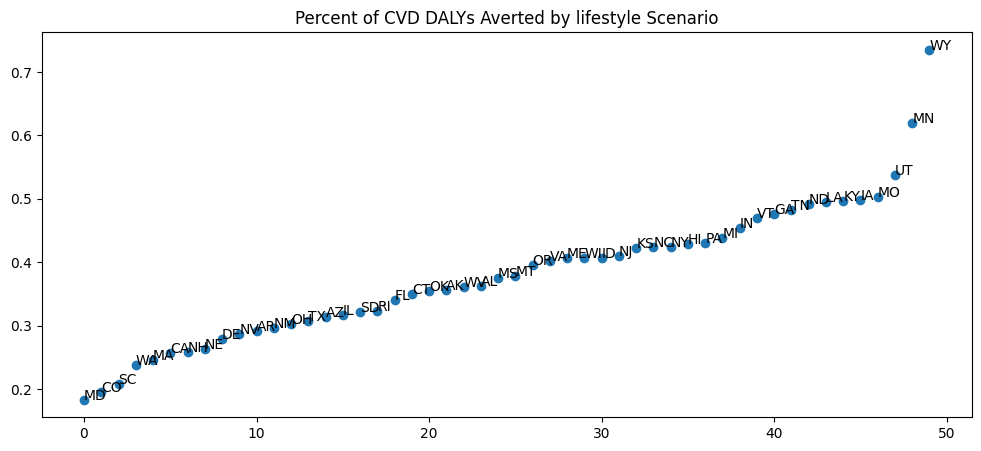

In [40]:
with PdfPages('daly_summary_dot_plot_11_9_23.pdf') as pdf:
    for intervention in ['outreach', 'polypill', 'lifestyle']:

        plt.figure(figsize=(12, 5))
        subdata = daly_state_rate_map.sort_values([f'averted_percent_mean_{intervention}'])
        y_error = [subdata[f'upper_error_{intervention}'], subdata[f'lower_error_{intervention}']]

        plt.errorbar(range(50), subdata[f'averted_percent_mean_{intervention}'], yerr=y_error, fmt='o') 

        for i in range(50):
            plt.annotate(subdata.abbreviation.iloc[i], (i, subdata[f'averted_percent_mean_{intervention}'].iloc[i] + 0.0002))

        plt.title(f'Percent of CVD DALYs Averted by {intervention} Scenario')
        pdf.savefig(bbox_inches='tight')
